In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    optimizers,
)

import sys
from pathlib import Path
sys.path.insert(0, str(Path("..").resolve()))

from utils import display, sample_batch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
img_size = 64
channels = 3
classes = 2
batch_size = 128
dims = 32
l_rate = 0.00005
adam_beta_1 = 0.5
adam_beta_2 = 0.9
epochs = 4 #20
critic_steps = 3
gp_weight = 10.0
label = "Blond_Hair"

### Preprocess the data

In [ ]:
attributes = pd.read_csv(r"\Autoencoders\list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [7]:
labels = attributes[label].tolist()
int_labels = [x if x == 1 else 0 for x in labels]

In [ ]:
train_data = utils.image_dataset_from_directory(
    r"\Autoencoders\img_align_celeba\img_align_celeba",
    labels=int_labels,
    color_mode="rgb",
    image_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 2 classes.


In [9]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = (train_data
        .map(lambda x, y: (preprocess(x), tf.one_hot(y, depth=classes)),  num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .prefetch(tf.data.AUTOTUNE))

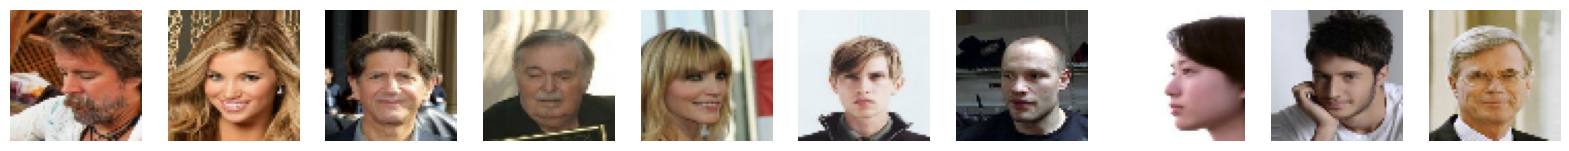

In [10]:
train_sample = sample_batch(train)
display(train_sample, cmap=None)

### Model

In [11]:
critic_input = layers.Input(shape=(img_size, img_size, channels))
label_input = layers.Input(shape=(img_size, img_size, classes))
x = layers.Concatenate(axis=-1)([critic_input, label_input])
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model([critic_input, label_input], critic_output)
critic.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 64, 64, 2) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64, 5) │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      5,184 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │    131,200 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ leaky_re_lu_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │    262,272 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8, 8, 128) │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8, 128) │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 128) │    262,272 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 4, 4, 128) │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4, 4, 128) │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 1, 1)   │      2,049 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ conv2d_4[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 662,977 (2.53 MB)

 Trainable params: 662,977 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
generator_input = layers.Input(shape=(dims,))
label_input = layers.Input(shape=(classes,))
x = layers.Concatenate(axis=-1)([generator_input, label_input])
x = layers.Reshape((1, 1, dims + classes))(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(channels, kernel_size=4, strides=2, padding="same", activation="tanh")(x)

generator = models.Model([generator_input, label_input], generator_output)
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 34)        │          0 │ input_layer_2[0]… │
│ (Concatenate)       │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 34)  │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 4, 4, 128) │     69,632 │ reshape[0][0]     │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 4, 4, 128) │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 4, 4, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 8, 8, 128) │    262,144 │ leaky_re_lu_4[0]… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 16, 16,    │    262,144 │ leaky_re_lu_5[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 32, 32,    │    131,072 │ leaky_re_lu_6[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 64, 64, 3) │      3,075 │ leaky_re_lu_7[0]… │
│ (Conv2DTranspose)   │                   │            │                 

 Total params: 729,859 (2.78 MB)

 Trainable params: 728,963 (2.78 MB)

 Non-trainable params: 896 (3.50 KB)

In [13]:
class ConditionalWGAN(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(ConditionalWGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(ConditionalWGAN, self).compile(run_eagerly=True)
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images, image_one_hot_labels):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic([interpolated, image_one_hot_labels], training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_images, one_hot_labels = data

        image_one_hot_labels = one_hot_labels[:, None, None, :]
        image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=img_size, axis=1)
        image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=img_size, axis=2)

        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                fake_images = self.generator([random_latent_vectors, one_hot_labels], training=True)

                fake_predictions = self.critic([fake_images, image_one_hot_labels], training=True)
                real_predictions = self.critic([real_images, image_one_hot_labels], training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(batch_size, real_images, fake_images, image_one_hot_labels)
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        with tf.GradientTape() as tape:
            fake_images = self.generator([random_latent_vectors, one_hot_labels], training=True)
            fake_predictions = self.critic([fake_images, image_one_hot_labels], training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [14]:
cgan = ConditionalWGAN(
    critic=critic,
    generator=generator,
    latent_dim=dims,
    critic_steps=critic_steps,
    gp_weight=gp_weight,
)

### Train

In [15]:
cgan.compile(
    c_optimizer=optimizers.Adam(learning_rate=l_rate, beta_1=adam_beta_1, beta_2=adam_beta_2),
    g_optimizer=optimizers.Adam(learning_rate=l_rate, beta_1=adam_beta_1, beta_2=adam_beta_2),
)

In [16]:
history = cgan.fit(
    train,
    epochs=epochs * 100,
    steps_per_epoch=1,
)

Epoch 1/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - c_gp: 0.7520 - c_loss: 7.4275 - c_wass_loss: -0.0929 - g_loss: 0.0893
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - c_gp: 0.7434 - c_loss: 7.2282 - c_wass_loss: -0.2053 - g_loss: 0.1697
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - c_gp: 0.7306 - c_loss: 6.9405 - c_wass_loss: -0.3651 - g_loss: 0.2592
Epoch 4/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - c_gp: 0.7153 - c_loss: 6.5578 - c_wass_loss: -0.5954 - g_loss: 0.3957
Epoch 5/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - c_gp: 0.6954 - c_loss: 6.0188 - c_wass_loss: -0.9350 - g_loss: 0.6333
Epoch 6/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - c_gp: 0.6698 - c_loss: 5.1312 - c_wass_loss: -1.5665 - g_loss: 0.9604
Epoch 7/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - c_gp: 0.6449 - c_loss: 4.2754 - c_wass_loss: -2.1731 - g_loss: 1.3584
Epoch 8/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - c_gp: 0.6072 - c_loss: 2.6728 - c_wass_loss: -3.3996 - g_loss: 1.9525
Epoch 9/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 6

### Generate new images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


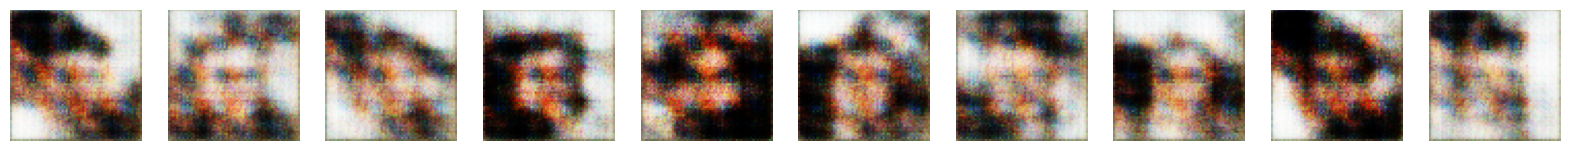

In [17]:
# 0 label
z_sample = np.random.normal(size=(10, dims))
class_label = np.repeat([[1, 0]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


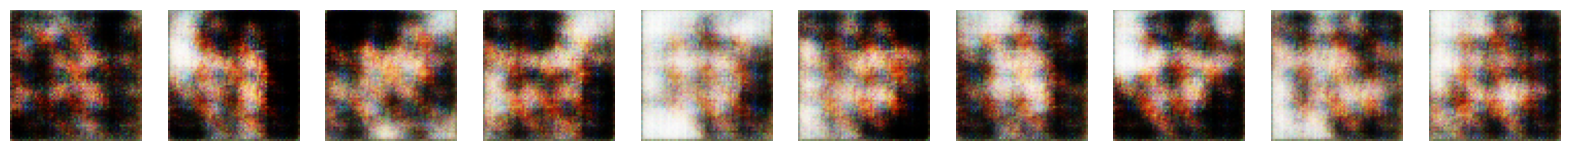

In [18]:
# 1 label
z_sample = np.random.normal(size=(10, dims))
class_label = np.repeat([[0, 1]], 10, axis=0)
imgs = cgan.generator.predict([z_sample, class_label])
display(imgs, cmap=None)